`KDD2024 Tutorial / A Hands-On Introduction to Time Series Classification and Regression`

# Interval-based Time Series Machine Learning in `aeon`

Interval-based approaches look at phase-dependent intervals of the full series, calculating summary statistics from selected subseries to be used in classification and regression. Interval-based approaches are particularly useful when the phase of the time series is important for the classification or regression task. Depending on the features extracted, interval-based approaches can be more resistant to noise than other phase-dependent approaches. For example, in the case of the ethanol level series below, the phase of the signal is important for determining the level of ethanol in a bottle of alcohol. A large amount of irrelevant high variation noise is present which would confound approaches such as distance-based.

Currently, seven published interval-based approaches are implemented in `aeon`, all of which can handle classification and five of which can handle regression. These are:

- Time Series Forest (TSF) [[1]](#references)
- Random Interval Spectral Ensemble (RISE) [[2]](#references)
- Canonical Interval Forest (CIF) [[3]](#references)
- Diverse Representation Canonical Interval Forest (DrCIF) [[4]](#references)
- Supervised Time Series Forest (STSF) [[5]](#references)
- Random Supervised Time Series Forest (RSTSF) [[6]](#references)
- QUANT [[7]](#references)

In this notebook, we will demonstrate how to use four interval-based estimators using our EEG example: TSF, DrCIF and RSTSF and QUANT.

<img src="./img/interval.png" alt="Ethanol level series with the discriminatory interval highlighted."><i>

## Table of Contents <a id='toc'></a>

* [Load example data](#load-data)
* [Time series forest (TSF)](#tsf)
    * [Classification with TSF](#tsf-clf)
    * [Regression with TSF](#tsf-reg)
* [Diverse representation canonical interval forest (DrCIF)](#drcif)
    * [Classification with DrCIF](#drcif-clf)
    * [Regression with DrCIF](#drcif-reg)
* [Random supervised time series forest (RSTSF)](#rstsf)
* [QUANT](#quant)
* [Performance on the UCR univariate classification datasets](#evaluation)
* [Configurable interval transformations](#transform)
* [References](#references)

In [ ]:
!pip install aeon==0.11.0 torch
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TEST.ts -P data/

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "interval"}, as_dataframe=True
)

,name,estimator
0,CanonicalIntervalForestClassifier,<class 'aeon.classification.interval_based._ci...
1,DrCIFClassifier,<class 'aeon.classification.interval_based._dr...
2,IntervalForestClassifier,<class 'aeon.classification.interval_based._in...
3,QUANTClassifier,<class 'aeon.classification.interval_based._qu...
4,RSTSF,<class 'aeon.classification.interval_based._rs...
5,RandomIntervalClassifier,<class 'aeon.classification.interval_based._in...
6,RandomIntervalSpectralEnsembleClassifier,<class 'aeon.classification.interval_based._ri...
7,SupervisedIntervalClassifier,<class 'aeon.classification.interval_based._in...
8,SupervisedTimeSeriesForest,<class 'aeon.classification.interval_based._st...
9,TimeSeriesForestClassifier,<class 'aeon.classification.interval_based._ts...


In [3]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "interval"}, as_dataframe=True
)

,name,estimator
0,CanonicalIntervalForestRegressor,<class 'aeon.regression.interval_based._cif.Ca...
1,DrCIFRegressor,<class 'aeon.regression.interval_based._drcif....
2,IntervalForestRegressor,<class 'aeon.regression.interval_based._interv...
3,RandomIntervalRegressor,<class 'aeon.regression.interval_based._interv...
4,RandomIntervalSpectralEnsembleRegressor,<class 'aeon.regression.interval_based._rise.R...
5,TimeSeriesForestRegressor,<class 'aeon.regression.interval_based._tsf.Ti...


## Load example data <a id='load-data'></a>

In [4]:
from aeon.datasets import load_from_tsfile

X_train_c, y_train_c = load_from_tsfile("./data/KDD_MTSC_TRAIN.ts")
X_test_c, y_test_c = load_from_tsfile("./data/KDD_MTSC_TEST.ts")

print("Train shape:", X_train_c.shape)
print("Test shape:", X_test_c.shape)

Train shape: (40, 4, 100)
Test shape: (40, 4, 100)


(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

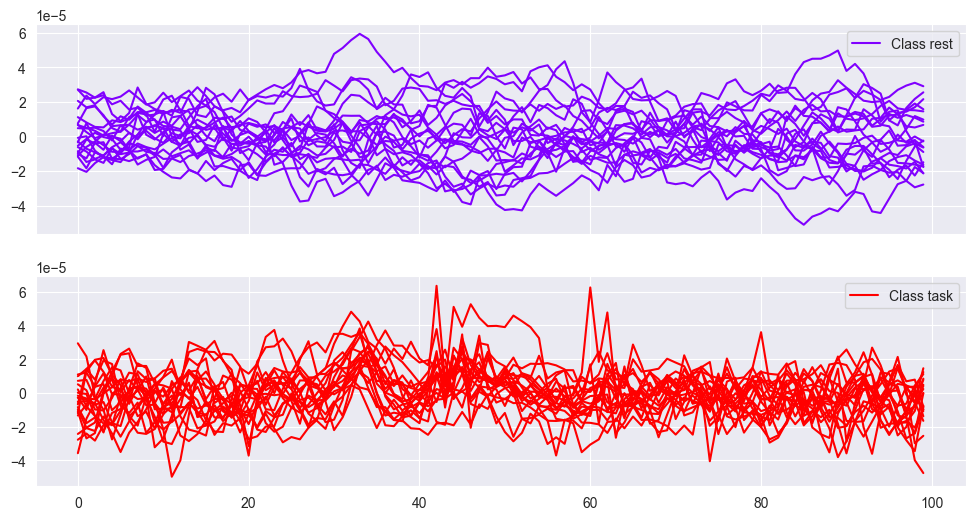

In [5]:
from aeon.visualisation import plot_collection_by_class

plot_collection_by_class(X_train_c[:,2,:], y_train_c)

In [6]:
X_train_r, y_train_r = load_from_tsfile("./data/KDD_MTSER_TRAIN.ts")
X_test_r, y_test_r = load_from_tsfile("./data/KDD_MTSER_TEST.ts")

print("Train shape:", X_train_r.shape)
print("Test shape:", X_test_r.shape)

Train shape: (72, 4, 100)
Test shape: (72, 4, 100)


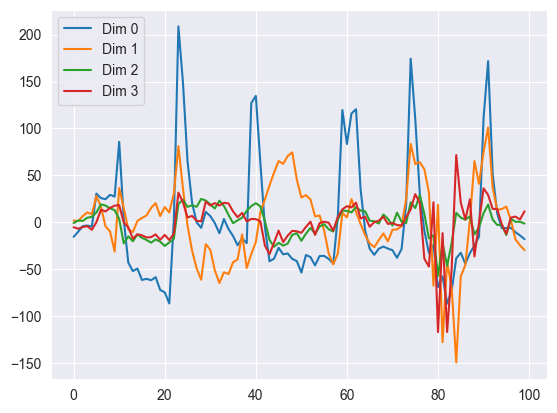

In [7]:
from matplotlib import pyplot as plt

plt.plot(X_train_r[0].T)
plt.legend(["Dim 0", "Dim 1", "Dim 2", "Dim 3"])

## Time series forest (TSF) <a id='tsf'></a>

The time series forest (TSF) [[1]](#references) is an ensemble of tree classifiers built on randomly selected intervals. For each tree, `sqrt(n_timepoints)` interval subseries are selected with random length and position. From each of these intervals the mean, standard deviation and slope is extracted from each time series and concatenated into a feature vector. These new features are then used to build the tree, which is added to the ensemble.

<img src="./img/ensemble.png" alt="Ensemble classifier."><i>

### Classification with TSF <a id='tsf-clf'></a>

The `TimeSeriesForestClassifier` class is an `aeon` classifier for the TSF algorithm. The classifier can be fitted to the training data and used to predict the class of the test data.

In [8]:
from sklearn.metrics import accuracy_score
from aeon.classification.interval_based import TimeSeriesForestClassifier

tsf_cls = TimeSeriesForestClassifier(random_state=42)
tsf_cls.fit(X_train_c, y_train_c)
tsf_preds_c = tsf_cls.predict(X_test_c)
accuracy_score(y_test_c, tsf_preds_c)

0.85

Interval based classifiers can provide insight into the importance of different parts of the time series. The `temporal_importance_curves` method returns the importance of each interval in the time series. These curves can be plotted to show the importance of different intervals and features in the time series.

Currently, only `BaseIntervalForest` estimators using the `ContinuousIntervalTree` base support creating temporal importance curves.

In the plot below, we show that extracting the standard deviation from the beginning and end of channel 0 and the beginning and middle of channel 1 are important for the classification task.

In [9]:
from aeon.classification.sklearn import ContinuousIntervalTree

tsf_tic = TimeSeriesForestClassifier(base_estimator=ContinuousIntervalTree(), random_state=42)
tsf_tic.fit(X_train_c, y_train_c)

TimeSeriesForestClassifier(base_estimator=ContinuousIntervalTree(),
                           random_state=42)

C:\Users\Matthew Middlehurst\AppData\Local\Temp\ipykernel_16564\4070484312.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


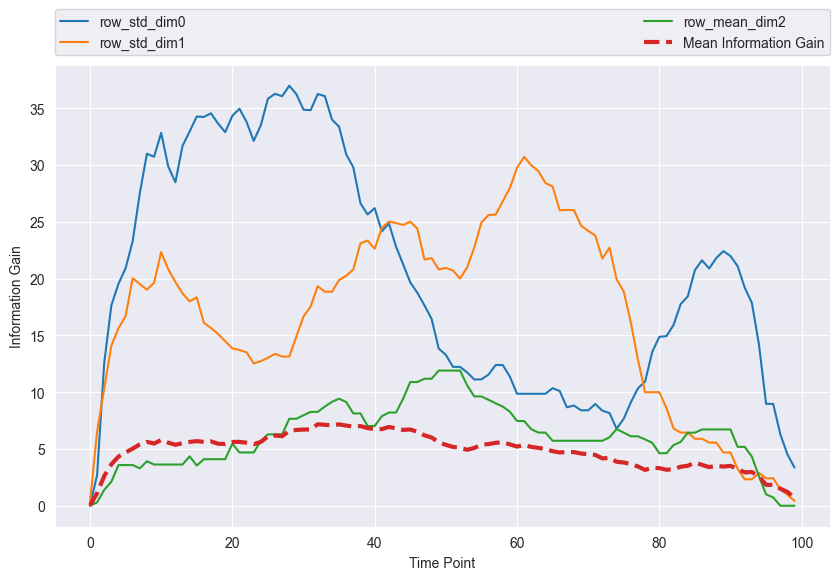

In [10]:
from aeon.visualisation import plot_temporal_importance_curves

names, curves = tsf_tic.temporal_importance_curves()
fig, ax = plot_temporal_importance_curves(curves, names, top_curves_shown=3, plot_mean=True)
fig.set_size_inches(10, 6)
fig.show()

### Regression with TSF <a id='tsf-reg'></a>

The `TimeSeriesForestRegressor` class is an `aeon` regressor for the TSF algorithm.

In [11]:
from sklearn.metrics import mean_squared_error
from aeon.regression.interval_based import TimeSeriesForestRegressor

tsf_reg = TimeSeriesForestRegressor(random_state=42)
tsf_reg.fit(X_train_r, y_train_r)
tsf_preds_r = tsf_reg.predict(X_test_r)
mean_squared_error(y_test_r, tsf_preds_r)

0.65566000777802

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

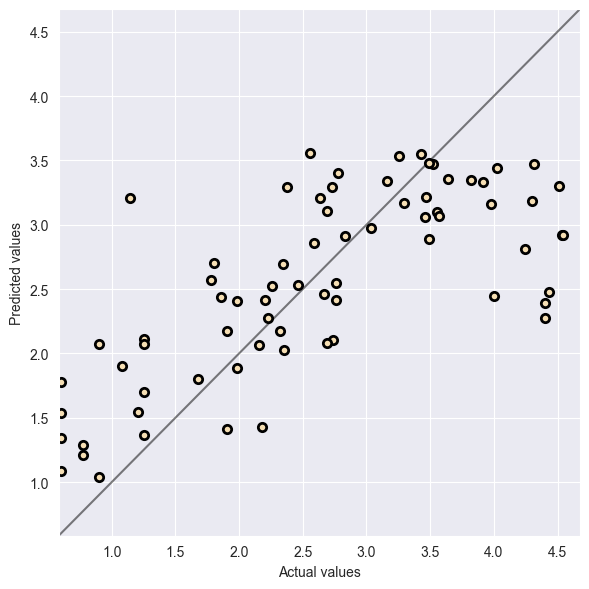

In [12]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, tsf_preds_r)

## Diverse representation canonical interval forest (DrCIF) <a id='drcif'></a>

The canonical interval forest (CIF) [[3]](#references) extends from the TSF algorithm. In addition to the three summary statistics used by TSF, CIF makes use of the features from the Catch22 [[8]](#references) transformation. To increase the diversity of the ensemble, the number of TSF and Catch22 attributes is randomly subsampled per tree, selecting eight by default. Intervals remain randomly selected.

DrCIF [[4]](#references) makes use of multiple series representations. The series is transformed into a periodogram and first order differences representations, and intervals are extracted from there as well.

While the Catch22 features are slower to calculate than the summary statistics, they are more informative and can improve the performance of the classifier.

<img src="./img/representations.png" alt="Different representations of time series."><i>

### Classification with DrCIF <a id='drcif-clf'></a>

The `DrCIFClassifier` class is an `aeon` classifier for the DrCIF algorithm. The algorithm performs well on our EEG example, achieving an accuracy of 0.95 on the below configuration.

Using the temporal importance curves plot, we can see that the most informative features come from the periodogram representation of the time series with the mean and max of the intervals from the end of the periodogram. The periodogram transform shortens the series, so the end of the curve plot from time point 64 onwards does not exist for this representation.

In [13]:
from aeon.classification.sklearn import ContinuousIntervalTree
from sklearn.metrics import accuracy_score
from aeon.classification.interval_based import DrCIFClassifier

cif_cls = DrCIFClassifier(n_estimators=100, base_estimator=ContinuousIntervalTree(), random_state=42)
cif_cls.fit(X_train_c, y_train_c)
cif_preds_c = cif_cls.predict(X_test_c)
accuracy_score(y_test_c, cif_preds_c)

0.95

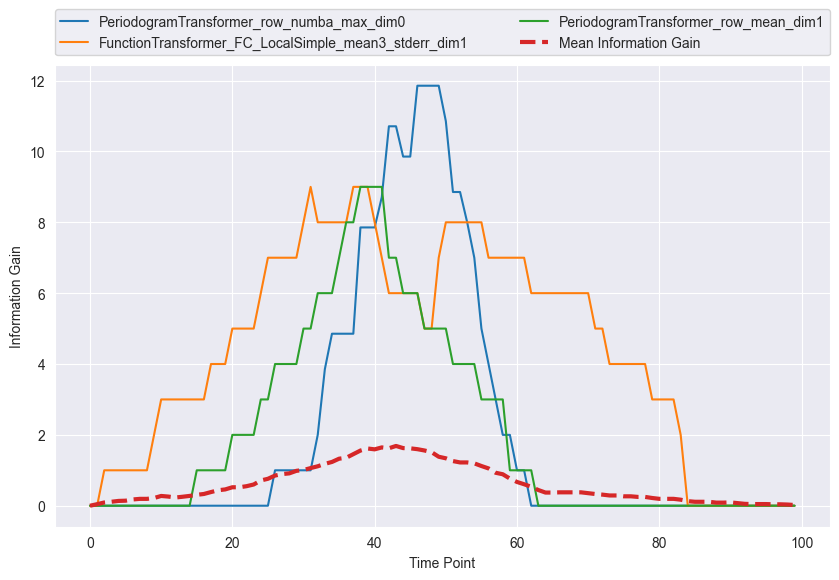

In [14]:
from aeon.visualisation import plot_temporal_importance_curves

names, curves = cif_cls.temporal_importance_curves()
fig, ax = plot_temporal_importance_curves(curves, names, top_curves_shown=3, plot_mean=True)
fig.set_size_inches(10, 6)

### Regression with DrCIF <a id='drcif-reg'></a>

The `DrCIFRegressor` class is an `aeon` regressor for the DrCIF algorithm.

In [15]:
from sklearn.metrics import mean_squared_error
from aeon.regression.interval_based import DrCIFRegressor

cif_reg = DrCIFRegressor(n_estimators=100, random_state=42)
cif_reg.fit(X_train_r, y_train_r)
cif_preds_r = cif_reg.predict(X_test_r)
mean_squared_error(y_test_r, cif_preds_r)

0.7120495131469782

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

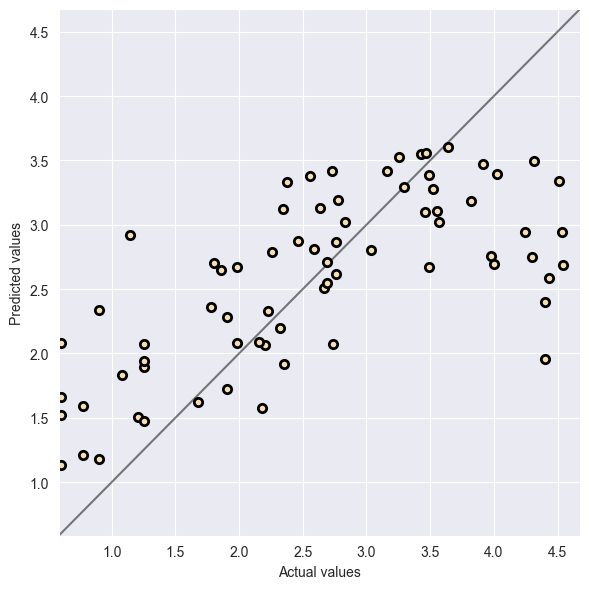

In [16]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, cif_preds_r)

## Random supervised time series forest (RSTSF) <a id='rstsf'></a>

The supervised time series forest (STSF) [[5]](#references) makes a number of adjustments from the original TSF algorithm. A supervised method of selecting intervals replaces random selection. Features are extracted from intervals generated from additional representations in periodogram and first order differences. Median, min, max and interquartile range are included in the summary statistics extracted.

RSTSF [[6]](#references) uses the same supervised process but with additional randomisation to increase diversity. Rather than an ensemble, the interbals are all extracted at once then used to build and extra trees classifier in a pipeline format.

The supervised interval extraction is only available for classification tasks currently. The `RSTSF` class is an `aeon` classifier for the RSTSF algorithm.

In [17]:
from aeon.classification.interval_based import RSTSF
from sklearn.metrics import accuracy_score

rstsf_cls = RSTSF(random_state=42)
rstsf_cls.fit(X_train_c, y_train_c)
rstsf_preds_c = rstsf_cls.predict(X_test_c)
accuracy_score(y_test_c, rstsf_preds_c)

0.95

## QUANT <a id='quant'></a>

The QUANT interval classifier extracts multiple quantiles from a fixed set of dyadic intervals. The series is continuously halved, with the quantiles from each subseries concatenated to form a feature vector. For each set of intervals extracted, the window is shifted by half the interval length to extract more intervals. Like previous algorithms, multiple series representations are used. The feature extraction is performed on the first order differences, second order differences, and a Fourier transform of the input series along with the original series.

Currently, the QUANT classifier is only available for classification tasks. The `QUANTClassifier` class is an `aeon` classifier for the QUANT algorithm. A version for regression will soon be available.

__Note:__ QUANT is implemented using `torch`. You will need to `pip install torch` to run this code.

<img src="./img/quant.png" alt="QUANT interval and feature extraction."><i>

In [18]:
from sklearn.metrics import accuracy_score
from aeon.classification.interval_based import QUANTClassifier

quant_cls = QUANTClassifier(random_state=42)
quant_cls.fit(X_train_c, y_train_c)
quant_preds_c = quant_cls.predict(X_test_c)
accuracy_score(y_test_c, quant_preds_c)

0.95

## Performance on the UCR univariate classification datasets <a id='evaluation'></a>

Below we show the performance of the interval classifiers we have introduced in this notebook on the UCR TSC archive datasets [[9]](#references) using results from a large scale comparison of TSC algorithms [[10]](#references). The results files are stored on [timeseriesclassification.com](timeseriesclassification.com).

In [19]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = ["TSF", "RISE", "CIF", "DrCIF", "STSF", "RSTSF", "QUANT", "1NN-DTW"]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 8)

In [20]:
import numpy as np

np.mean(results, axis=0)

array([0.78949898, 0.79287376, 0.83218294, 0.84985472, 0.82956842,
       0.84855813, 0.85439771, 0.74206624])

(<Figure size 600x270 with 1 Axes>, <Axes: >)

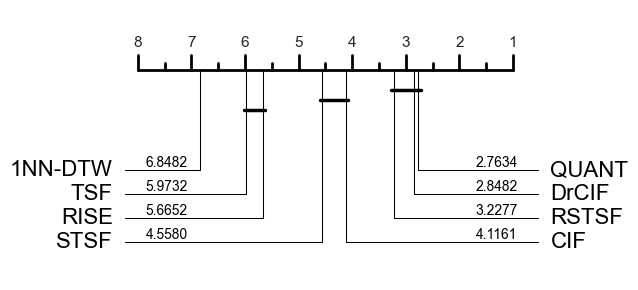

In [21]:
from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

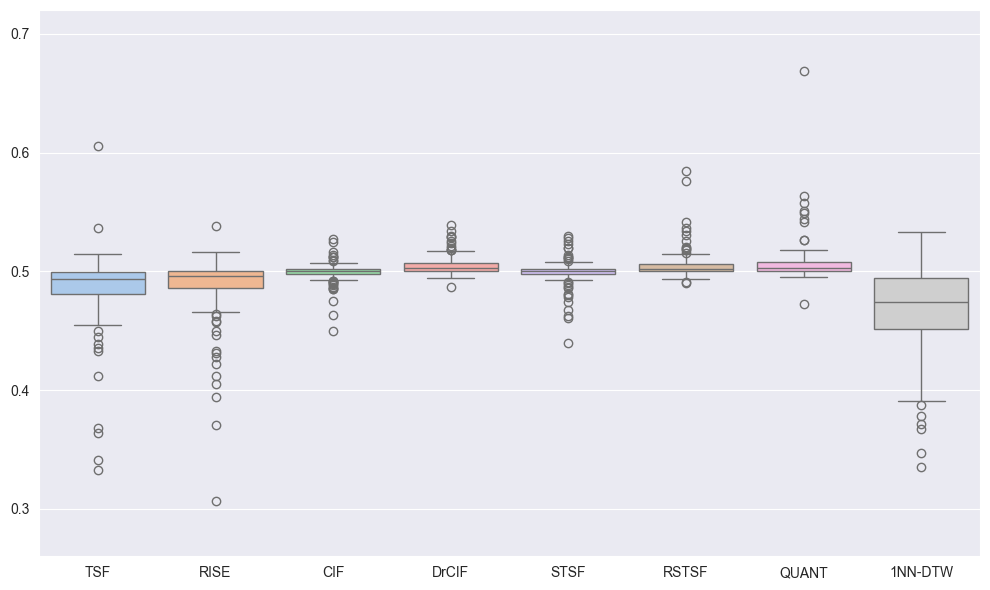

In [22]:
from aeon.visualisation import plot_boxplot_median

plot_boxplot_median(results, names, plot_type="boxplot")

## Configurable interval transformations <a id='transform'></a>

`aeon` has transformation classes available for both the random and supervised methods of interval extraction.

In [23]:
from aeon.transformations.collection.interval_based import RandomIntervals
from aeon.utils.numba.stats import row_mean, row_std

rand_int = RandomIntervals(n_intervals=3, features=[row_mean, row_std])
rand_int.fit(X_train_c)
rand_int.transform(X_train_c)

array([[ 2.79178773e-06,  7.00553355e-06, -1.03336568e-05,
         5.91278019e-06, -1.21532110e-06,  1.40214100e-05],
       [-1.19249840e-05,  1.92607752e-05, -7.73571803e-07,
         7.83381023e-06,  2.04542303e-06,  1.54176836e-05],
       [ 2.16624288e-08,  1.23857351e-05, -5.97589174e-06,
         5.10042374e-06,  4.82148204e-07,  1.32838369e-05],
       [-1.21167348e-05,  6.15997514e-06, -4.79926485e-06,
         4.29394145e-06,  6.99026606e-07,  1.55456224e-05],
       [ 3.06131845e-06,  1.22718683e-05, -2.02003339e-06,
         8.36990447e-06,  2.81618386e-06,  1.43893458e-05],
       [ 1.01280600e-05,  4.36681589e-06, -5.95266932e-06,
         8.26655474e-06,  4.97379146e-06,  1.57106994e-05],
       [-6.61164787e-06,  9.12496777e-06,  1.10538169e-06,
         5.59794057e-06,  1.32845475e-06,  1.31395063e-05],
       [-1.38681897e-05,  1.06896067e-05,  1.05977125e-06,
         4.68217327e-06,  5.82584819e-06,  1.51930658e-05],
       [ 3.79417107e-06,  6.62607155e-06,  5.787

In [24]:
from aeon.transformations.collection.interval_based import SupervisedIntervals

sup_int = SupervisedIntervals(n_intervals=1, features=[row_mean, row_std])
sup_int.fit(X_train_c, y_train_c)
sup_int.transform(X_train_c)

array([[-1.53204310e-05, -1.69415540e-05, -2.00034729e-05, ...,
         7.49260582e-06,  8.78522462e-06,  3.27827601e-06],
       [-1.03658132e-05,  3.88462199e-06, -1.61891666e-06, ...,
         6.11356875e-06,  7.19938184e-06,  5.92081090e-06],
       [-2.79596369e-06, -3.78408311e-06, -3.50255592e-06, ...,
         5.39698660e-06,  5.51183168e-06,  3.62738874e-06],
       ...,
       [ 1.86491690e-05,  1.94140163e-05,  1.70760024e-05, ...,
         5.51905175e-06,  3.94290242e-06,  4.84783972e-06],
       [-4.50684085e-06,  8.65383598e-07,  2.33870474e-06, ...,
         4.34097676e-06,  3.98221724e-06,  2.79533143e-06],
       [ 2.98438226e-05,  1.28175026e-05,  1.72065405e-05, ...,
         5.63069008e-06,  5.77779821e-06,  3.77031967e-06]])

A composable class is also available for both classification and regression, allowing for a configurable interval extraction ensemble.

In [25]:
from aeon.utils.numba.stats import row_mean, row_std, row_numba_max, row_numba_min
from aeon.classification.interval_based import IntervalForestClassifier
from aeon.classification.sklearn import ContinuousIntervalTree
from aeon.transformations.collection import PeriodogramTransformer
from sklearn.metrics import accuracy_score

int_clf = IntervalForestClassifier(
    base_estimator=ContinuousIntervalTree(),
    interval_selection_method="random",
    n_intervals=10,
    interval_features=[row_numba_min, row_numba_max, row_mean, row_std],
    series_transformers=[None, PeriodogramTransformer()],
    random_state=42,
)
int_clf.fit(X_train_c, y_train_c)
int_preds_c = int_clf.predict(X_test_c)
accuracy_score(y_test_c, int_preds_c)

0.775

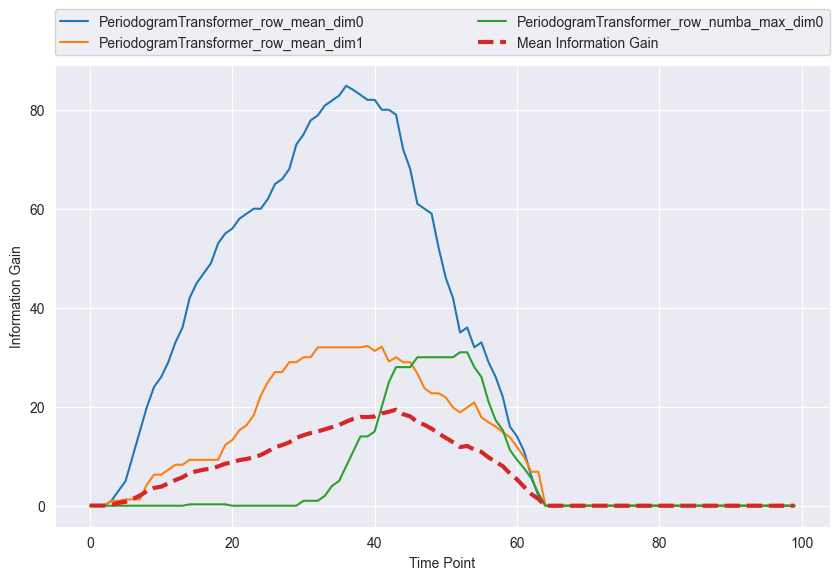

In [26]:
from aeon.visualisation import plot_temporal_importance_curves

names, curves = int_clf.temporal_importance_curves()
fig, ax = plot_temporal_importance_curves(curves, names, top_curves_shown=3, plot_mean=True)
fig.set_size_inches(10, 6)

## References <a id='references'></a>

[1] Deng, Houtao, et al. "A time series forest for classification and feature extraction." Information Sciences 239 (2013): 142-153.

[2] Flynn, Michael, James Large, and Tony Bagnall. "The contract random interval spectral ensemble (c-RISE): The effect of contracting a classifier on accuracy." Hybrid Artificial Intelligent Systems: 14th International Conference, HAIS 2019, León, Spain, September 4–6, 2019, Proceedings 14. Springer International Publishing, 2019.

[3] Middlehurst, Matthew, James Large, and Anthony Bagnall. "The canonical interval forest (CIF) classifier for time series classification." 2020 IEEE international conference on big data (big data). IEEE, 2020.

[4] Middlehurst, Matthew, et al. "HIVE-COTE 2.0: a new meta ensemble for time series classification." Machine Learning 110.11 (2021): 3211-3243.

[5] Cabello, Nestor, et al. "Fast and accurate time series classification through supervised interval search." 2020 IEEE International Conference on Data Mining (ICDM). IEEE, 2020.

[6] Cabello, Nestor, et al. "Fast, accurate and explainable time series classification through randomization." Data Mining and Knowledge Discovery 38.2 (2024): 748-811.

[7] Dempster, Angus, Daniel F. Schmidt, and Geoffrey I. Webb. "Quant: A minimalist interval method for time series classification." Data Mining and Knowledge Discovery (2024): 1-26.

[8] Lubba, Carl H., et al. "catch22: CAnonical Time-series CHaracteristics: Selected through highly comparative time-series analysis." Data Mining and Knowledge Discovery 33.6 (2019): 1821-1852.

[9] Dau, Hoang Anh, et al. "The UCR time series archive." IEEE/CAA Journal of Automatica Sinica 6.6 (2019): 1293-1305.

[10] Middlehurst, Matthew, Patrick Schäfer, and Anthony Bagnall. "Bake off redux: a review and experimental evaluation of recent time series classification algorithms." Data Mining and Knowledge Discovery (2024): 1-74.

[Return to Table of Contents](#toc)